In [15]:
# Import necessary libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns




In [17]:
# 1. Data Loading and Preprocessing
def load_images_and_labels(data_folder, img_size=(224, 224)):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_folder))
    print("Loading images and labels...")
    for class_name in class_names:
        class_folder = os.path.join(data_folder, class_name)
        image_files = os.listdir(class_folder)
        for image_file in image_files:
            img_path = os.path.join(class_folder, image_file)
            # Load image in RGB
            img = cv2.imread(img_path)
            if img is not None:
                # Resize image
                img_resized = cv2.resize(img, img_size)
                images.append(img_resized)
                labels.append(class_name)
    return images, labels

# Specify the path to your preprocessed data folder
data_folder = 'preprocessed_data'  # Update this path if necessary

# Load images and labels
images, labels = load_images_and_labels(data_folder)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

Loading images and labels...


In [ ]:


# 2. Encode Labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
class_names = label_encoder.classes_
num_classes = len(class_names)
print(f"Classes: {class_names}")

# Binarize labels for ROC AUC
labels_binarized = label_binarize(labels_encoded, classes=np.arange(num_classes))

# 3. Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(
    images, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded)

# 4. Data Preprocessing and Augmentation
# Define ImageDataGenerators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # VGG16 preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create generators
batch_size = 32

train_generator = train_datagen.flow(
    X_train, y_train, batch_size=batch_size
)

val_generator = val_datagen.flow(
    X_val, y_val, batch_size=batch_size
)



Classes: ['Acne and Rosacea Photos' 'Atopic Dermatitis Photos' 'Eczema Photos'
 'Herpes HPV and other STDs Photos' 'Melanoma Skin Cancer Nevi and Moles'
 'Poison Ivy Photos and other Contact Dermatitis'
 'Psoriasis pictures Lichen Planus and related diseases' 'Urticaria Hives'
 'Vascular Tumors' 'Warts Molluscum and other Viral Infections']


In [ ]:
# 5. Build the Model using VGG16
def build_vgg16_model(num_classes):
    # Load the VGG16 model without the top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the full model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

model = build_vgg16_model(num_classes)

# 6. Compile the Model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

# 7. Define Callbacks
class LogMetrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"Epoch {epoch +1}: "
              f"loss = {logs.get('loss'):.4f}, "
              f"accuracy = {logs.get('accuracy'):.4f}, "
              f"val_loss = {logs.get('val_loss'):.4f}, "
              f"val_accuracy = {logs.get('val_accuracy'):.4f}")

callbacks = [
    LogMetrics(),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_vgg16_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# 8. Train the Model
epochs = 10  # You can adjust this based on your computational constraints

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks
)



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

C:\Users\amank\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1028 - loss: 6.0030Epoch 1: loss = 4.7274, accuracy = 0.1218, val_loss = 2.4877, val_accuracy = 0.2229

Epoch 1: val_loss improved from inf to 2.48773, saving model to best_vgg16_model.keras
198/198 ━━━━━━━━━━━━━━━━━━━━ 1047s 5s/step - accuracy: 0.1029 - loss: 5.9966 - val_accuracy: 0.2229 - val_loss: 2.4877 - learning_rate: 1.0000e-04
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1597 - loss: 2.8865Epoch 2: loss = 2.7250, accuracy = 0.1592, val_loss = 2.1649, val_accuracy = 0.2683

Epoch 2: val_loss improved from 2.48773 to 2.16492, saving model to best_vgg16_model.keras
198/198 ━━━━━━━━━━━━━━━━━━━━ 1038s 5s/step - accuracy: 0.1597 - loss: 2.8857 - val_accuracy: 0.2683 - val_loss: 2.1649 - learning_rate: 1.0000e-04
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1929 - loss: 2.3631Epoch 3: loss = 2.3147, accuracy = 0.2027, val_loss = 2.0573, val_accuracy = 0.2980

Epoch 3: val_loss imp

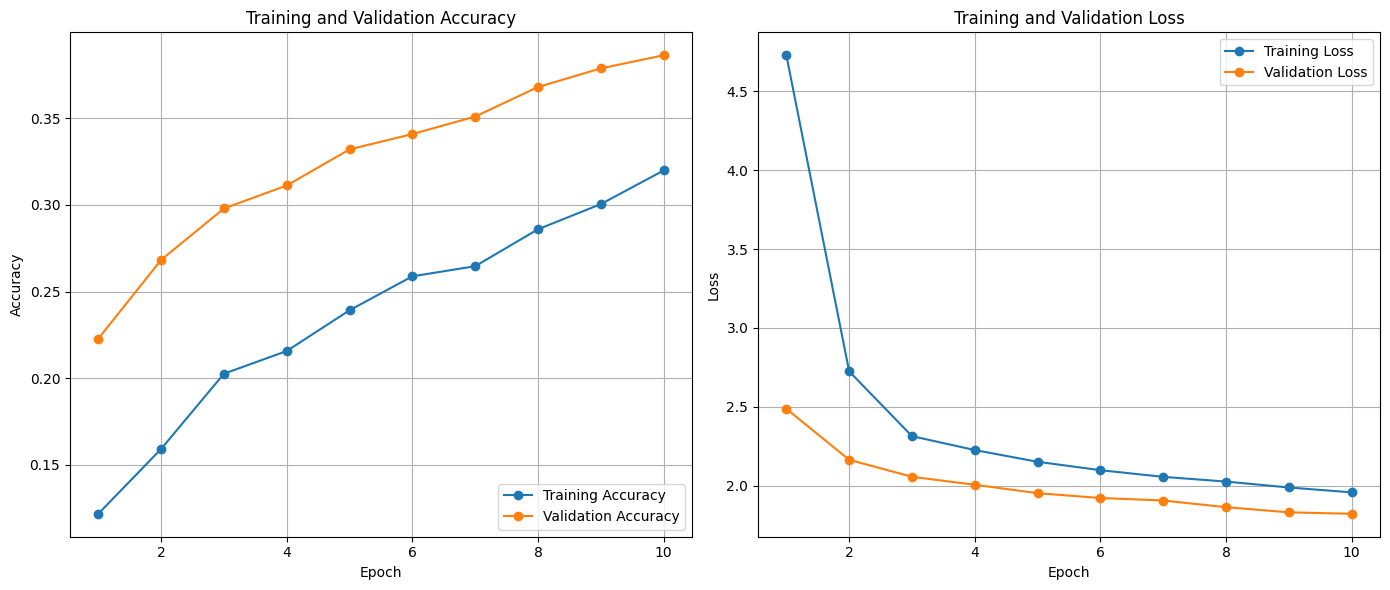

50/50 ━━━━━━━━━━━━━━━━━━━━ 217s 4s/step
ROC AUC Score: 0.5039
Classification Report:
                                                       precision    recall  f1-score   support

                              Acne and Rosacea Photos       0.11      0.21      0.15       164
                             Atopic Dermatitis Photos       0.10      0.06      0.07       137
                                        Eczema Photos       0.13      0.21      0.16       201
                     Herpes HPV and other STDs Photos       0.05      0.03      0.04       138
                  Melanoma Skin Cancer Nevi and Moles       0.12      0.09      0.11       138
       Poison Ivy Photos and other Contact Dermatitis       0.06      0.02      0.03       138
Psoriasis pictures Lichen Planus and related diseases       0.17      0.19      0.18       206
                                      Urticaria Hives       0.10      0.07      0.08       137
                                      Vascular Tumors      

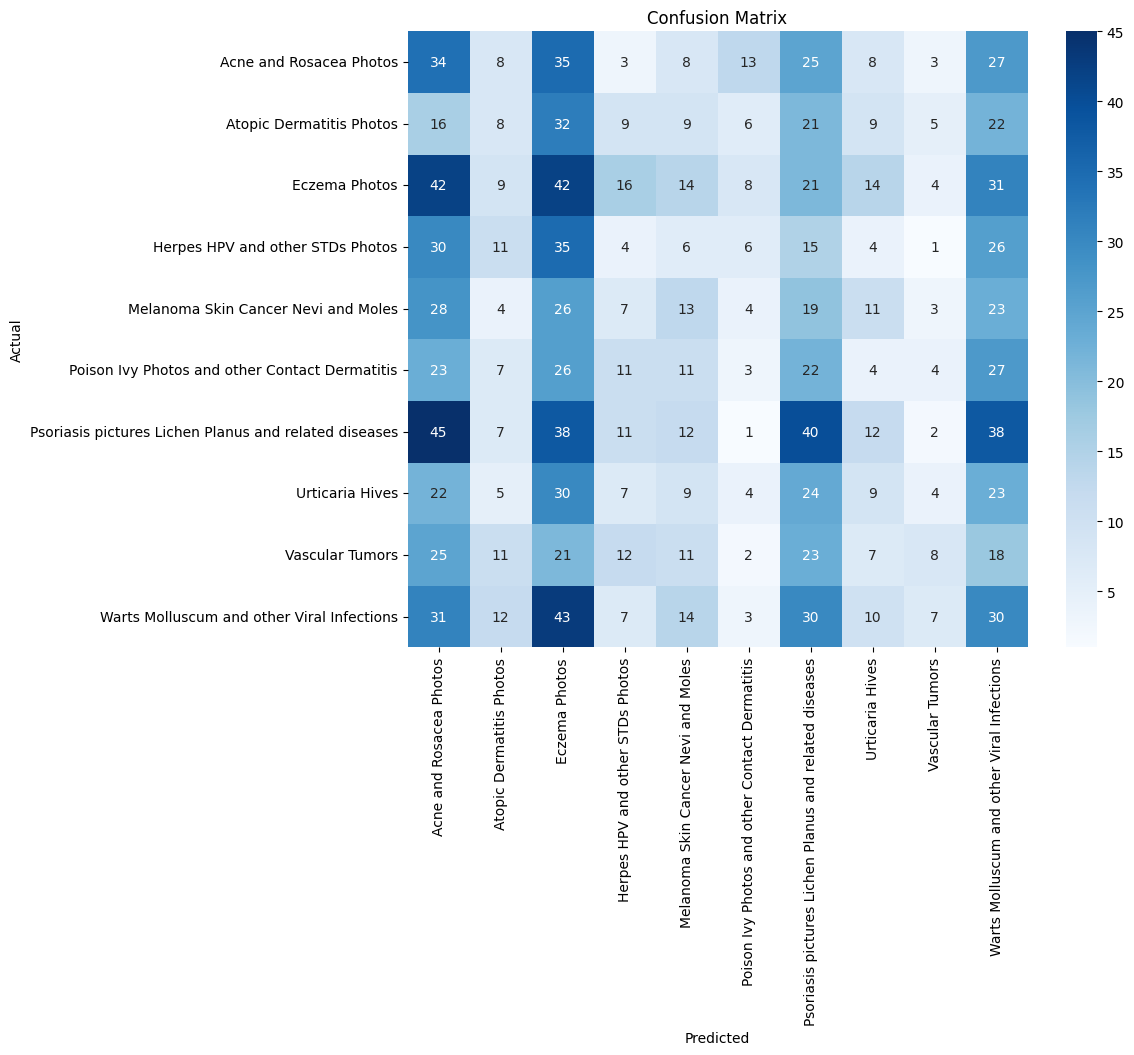

Model saved as 'final_vgg16_model.keras'


In [ ]:
# 9. Plot Training & Validation Accuracy and Loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# 10. Evaluate the Model
def evaluate_model(model, val_generator, y_val, class_names):
    # Get predictions
    val_generator.reset()
    predictions = model.predict(val_generator, steps=len(val_generator), verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    
    # Compute ROC AUC Score
    y_val_binarized = label_binarize(y_val, classes=np.arange(num_classes))
    if num_classes == 2:
        roc_auc = roc_auc_score(y_val_binarized, predictions[:,1])
    else:
        roc_auc = roc_auc_score(y_val_binarized, predictions, average='macro', multi_class='ovr')
    print(f"ROC AUC Score: {roc_auc:.4f}")
    
    # Classification Report
    report = classification_report(y_val, y_pred, target_names=class_names)
    print("Classification Report:")
    print(report)
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Convert y_val back to original labels for evaluation
evaluate_model(model, val_generator, y_val, class_names)

# 11. Save the Final Model
model.save('final_vgg16_model.keras')
print("Model saved as 'final_vgg16_model.keras'")